In [22]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as smg
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn import preprocessing
import arviz as az


settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

### Plot helpers

In [3]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

### Data

In [ ]:
data = pd.read_csv(r'../data/startups.csv', index_col=[0], date_format="mm/dd/yyyy")
data.rename(columns = {'All Economic Activities, Total Business Start-Ups': 'Startups',
                       'All Economic Activities, 1 Employed Person or Less': 'Startups_1_person',
                       'All Economic Activities, 2 to 10 Employed Person or Less': 'Startups_2_10_person',
                       'All Economic Activities, 10 to 50 Employed Person or Less': 'Startups_10_50_person',
                       'All Economic Activities, 50 to 250 Employed Person or Less': 'Startups_50_250_person',
}, inplace = True)
data.columns
data.drop(columns=['All Economic Activities, 250 Employees or More'], inplace=True)
data.iloc[:,0:4].plot()

In [ ]:
#data.corr()

In [15]:
data_diff = data.diff()
data_diff.corr().to_csv('../output/data_diff_corr.csv')


In [41]:
data_sub = data[['Startups',
     'Netherlands, GDP [thousands]',
     'Netherlands, Three month money market rate',
     'Netherlands, Eurostat, HICP, All-Items HICP, 2015=100, Index', 
     'Netherlands, OECD Economic Outlook, Hours Worked per Worker, Total Economy, Estimate, Calendar Adjusted, SA',
     'Netherlands, Lending Surveys, Central Bank of Netherlands, Bank Lending Survey, Credit Standards Past 3 Months, Enterprises, Total',
     'Euro Area 19, Long term interest rate',
     'World, Crude Oil, Brent, Spot, FOB North Sea, ICE, Close, USD'
     ]]

data_sub.corr().to_csv(r'../output/data_diff_sub_corr.csv')

In [42]:
data_sub.to_csv("tmp.csv")

<Axes: >

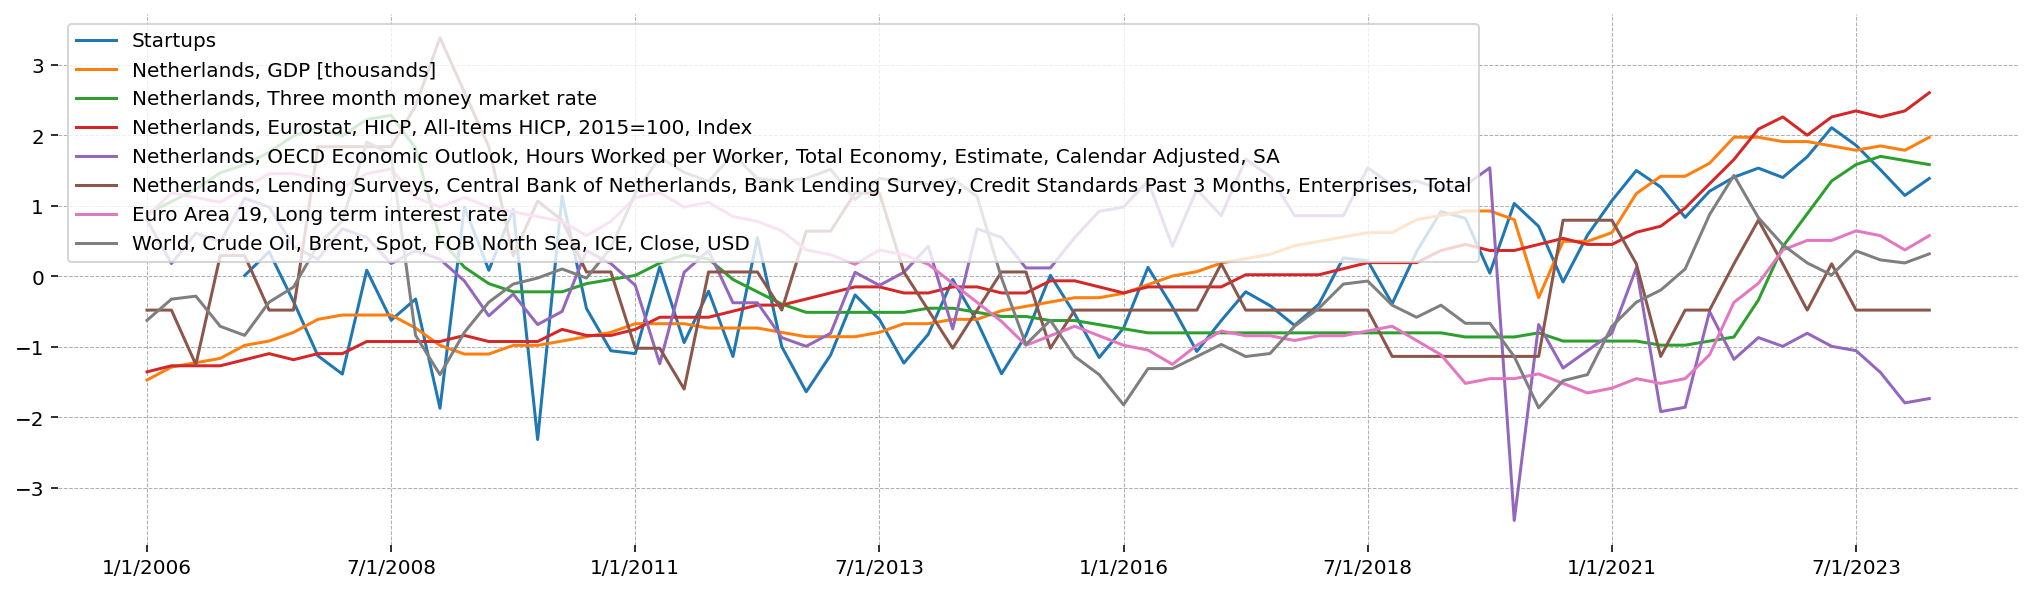

In [46]:
data_sub_stdz = data_sub.copy()
scaler = preprocessing.StandardScaler().fit(data_sub_stdz)
data_sub_stdz = scaler.transform(data_sub_stdz)

data_sub_stdz = pd.DataFrame(data_sub_stdz)
data_sub_stdz.columns = data_sub.columns
data_sub_stdz.index = data_sub.index
data_sub_stdz.plot()